**Before running the notebook** To link Kaggle and Colab you need to have downloaded the API from kaggle (On kaggle click on the top right icon thing > account > Create new API). Once you have downloaded the API file,  you will have to add it in this notebook under files. Either upload it or drag and drop. Everytime you need to run the notebook you will have to add the downloaded API file in this notebook

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! kaggle competitions download EDSA-Movie-Recommendation-Predict

 94% 225M/239M [00:02<00:00, 82.7MB/s]
100% 239M/239M [00:02<00:00, 97.2MB/s]


In [5]:
! unzip EDSA-Movie-Recommendation-Predict.zip

Archive:  EDSA-Movie-Recommendation-Predict.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: imdb_data.csv           
  inflating: links.csv               
  inflating: movies.csv              
  inflating: sample_submission.csv   
  inflating: tags.csv                
  inflating: test.csv                
  inflating: train.csv               


# Movie Recommendation Predict

![image info](https://user-images.githubusercontent.com/33485020/108069438-5ee79d80-7089-11eb-8264-08fdda7e0d11.jpg)

### Honour Code

Idongesit Bokeime, Ngawetu Mtirara, Daniel Uwaoma, Sibusiso Sibiya, Nonokazi Cele, Mbuyiselo Mkwanazi, Collins Kgooho and Pharis Ihaki (Team_CW3), confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


### Problem Statement

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity. (To be fixed, copied from kaggle)

### Objectives

1.   Explore and visualize the dataset.
2.   Clean and engineer the dataset.
3.   Build multiple models that will analyse sentiments on climate change      make the necesssary predictions.
4.   Assess the accuracy of the models.
5.   Choose the best model to make predictions.


### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
---
2. [Load Dependencies](#imports)
 * Connecting to Comet
 * Libraries
 * Data
 * Data Definitions
---
3. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Missing Values
 * Ratings
 * Genres
 * IMDB Metadata
---
4. [Data Preprocessing](#preprocessing)
 * Multidimensional Scaling
 * Principle Component Analysis
 * Cluster Analysis
---
5. [Modelling](#modelling)
 * Collaborative Filtering
 * Content-based Filtering
---
6. [Performance Evaluation](#evaluation)
 * Root Mean Squared Error (RMSE)
 * Cross Validation
---
7. [Model Analysis](#analysis)
 * Hyperparameter Tuning
 * Results
---
8. [Conclusion](#conclusion)
---
9. [Save Output](#ref)
---
10. [References](#save)
--- 




 <a id="two"></a>
## 1. Importing Packages

In [6]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

<a id="three"></a>
### 1.1. Loading the Data
<a class="anchor" id="1.1">

In [7]:
# Loading the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
movies_df = pd.read_csv('/content/movies.csv')
tags_df = pd.read_csv('/content/tags.csv')
links_df = pd.read_csv('/content/links.csv')
imdb_df = pd.read_csv('/content/imdb_data.csv')
genome_tags_df = pd.read_csv('/content/genome_tags.csv')
genome_scores_df = pd.read_csv('/content/genome_scores.csv')

<a id="section-two"></a>
## 2. Dataset at a glance

In [8]:
#function that displays the first five raws of a data frame
def display_df(df):
    '''This functions takes in a dataframe and returns the first five raws of it'''
    return df.head()

In [9]:
#define a data frame summary statistic function
def summary_stat(df):
    '''This function takes a dataframe and returns the summary statistics of all numerical columns'''
    return df.describe()

In [20]:
#define a function that displays the information of a df
def display_info(df):
    '''This function takes in a dataframe and  returns the information about a dataframe'''
    return df.info()

In [10]:
# define a function for checking missing values
def missing_val(df):
    '''A function that checks for missing values per column when passing in a dataframe
    and returns the count of missing values in each column'''
    # Count total NaN at each column in a DataFrame
    count = print(" \nCount total NaN at each column in a DataFrame : \n\n",
              df.isnull().sum())
    return count

##2.1 imdb DataFrame

In [11]:
display_df(imdb_df)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [12]:
summary_stat(imdb_df)

,movieId,runtime
count,27278.000000,15189.000000
mean,59855.480570,100.312331
std,44429.314697,31.061707
min,1.000000,1.000000
25%,6931.250000,89.000000
50%,68068.000000,98.000000
75%,100293.250000,109.000000
max,131262.000000,877.000000


In [13]:
missing_val(imdb_df)

 
Count total NaN at each column in a DataFrame : 

 movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


## 2.2. Movies DataFrame

In [14]:
display_df(movies_df)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
summary_stat(movies_df)

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [16]:
missing_val(movies_df)

 
Count total NaN at each column in a DataFrame : 

 movieId    0
title      0
genres     0
dtype: int64


### 2.3. Merged DataFrame

In [17]:
# Inner join movies and imdb dataset to ensure we are working with the same set of movies
main_df = movies_df.merge(imdb_df, how = 'inner', on = 'movieId')
main_df = main_df.merge(tags_df, how = 'left', on = 'movieId')
display_df(main_df)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,1361.0,Pixar,1.216146e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,3164.0,Pixar,1.223305e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,3164.0,time travel,1.223305e+09


In [18]:
main_df['release_year'] = main_df["title"].str.extract(r"\((\d{4})\)$", expand=False)
main_df["release_year"] = pd.to_numeric(main_df["release_year"])
main_df["title"] = main_df.title.str.replace(r"\((\d{4})\)$", "")
main_df.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,tag,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,791.0,Owned,1.515175e+09,1995.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,1048.0,imdb top 250,1.172144e+09,1995.0


In [21]:
# Getting to know our dataset
display_info(main_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905137 entries, 0 to 905136
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movieId        905137 non-null  int64  
 1   title          905137 non-null  object 
 2   genres         905137 non-null  object 
 3   title_cast     677587 non-null  object 
 4   director       678498 non-null  object 
 5   runtime        663981 non-null  float64
 6   budget         584923 non-null  object 
 7   plot_keywords  675004 non-null  object 
 8   userId         903067 non-null  float64
 9   tag            903051 non-null  object 
 10  timestamp      903067 non-null  float64
 11  release_year   904390 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 89.8+ MB


The main_df dataset merged between the movies and imbd dataframe contains 2 columns 4 of float type, 1 of int type and 7 of object type, It is also observed that there are a total of 905137 entries

In [22]:
summary_stat(main_df)

,movieId,runtime,userId,timestamp,release_year
count,905137.00000,663981.000000,903067.000000,9.030670e+05,904390.000000
mean,37343.31616,115.432430,70406.209121,1.410597e+09,1995.818665
std,40097.93755,25.505062,51059.813282,1.200614e+08,17.936289
min,1.00000,1.000000,3.000000,1.135429e+09,1891.000000
25%,2686.00000,99.000000,21096.000000,1.310320e+09,1990.000000
50%,8574.00000,112.000000,64333.000000,1.440891e+09,2001.000000
75%,71535.00000,128.000000,115820.000000,1.527145e+09,2008.000000
max,131262.00000,877.000000,162521.000000,1.574311e+09,2015.000000


In [23]:
missing_val(main_df)

 
Count total NaN at each column in a DataFrame : 

 movieId               0
title                 0
genres                0
title_cast       227550
director         226639
runtime          241156
budget           320214
plot_keywords    230133
userId             2070
tag                2086
timestamp          2070
release_year        747
dtype: int64


From the above, it can be seen that only three of the columns of the dataframe have no missing values, the rest have significant amount of missing values and these need to handled properly

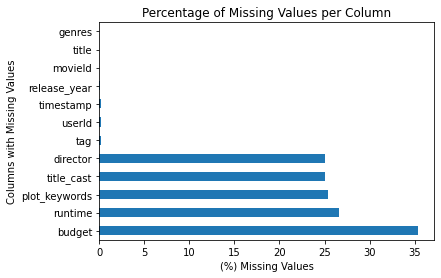

In [24]:
# The percentage of each column of missing values
total = main_df.isnull().sum().sort_values(ascending=False)
percent_1 = main_df.isnull().sum()/main_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2],
                         axis=1, keys=['Total', '(%) missing'])
missing_data['(%) missing'].plot(kind='barh')
plt.xlabel('(%) Missing Values')
plt.ylabel('Columns with Missing Values')
plt.title('Percentage of Missing Values per Column')
plt.show()

There are two methods to handle missing data, dropping the columns or imputation. Imputation is a treatment method for missing value by filling it in using certain techniques. Can use mean, mode, or use predictive modeling.

In [25]:
main_df.director.fillna("No Director", inplace=True)
main_df.title_cast.fillna("No Cast", inplace=True)

The easiest way to handle missing data would be to delete the rows with the missing. However, this wouldn’t be beneficial, since it is a loss of information. Since “director,” “cast,” and  contain the majority of null values.

<a id="section-two"></a>
## 3. Exploratory data analysis

## 3.1. Runtime Distribution

Average movie runtime: 115.43242954241161


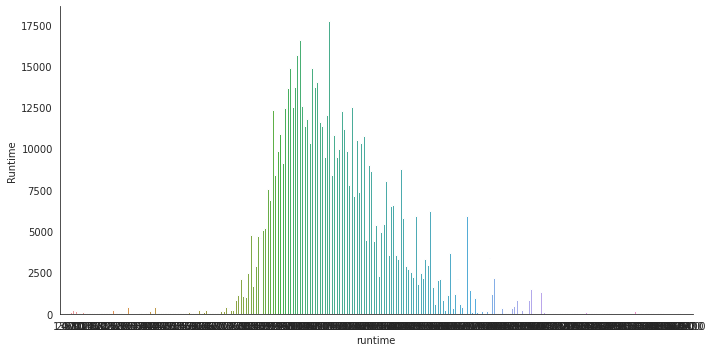

In [26]:
# Ploting our runtime to see the distribution
with sns.axes_style('white'):
    g = sns.factorplot("runtime", data=main_df, aspect=2.0,kind='count')
    g.set_ylabels("Runtime")
print (f'Average movie runtime: {np.mean(main_df["runtime"])}')

The movies are distributed mostly at the center (averagely 103 minutes).
Dropping the outliers.

## 3.2. Most popular genres

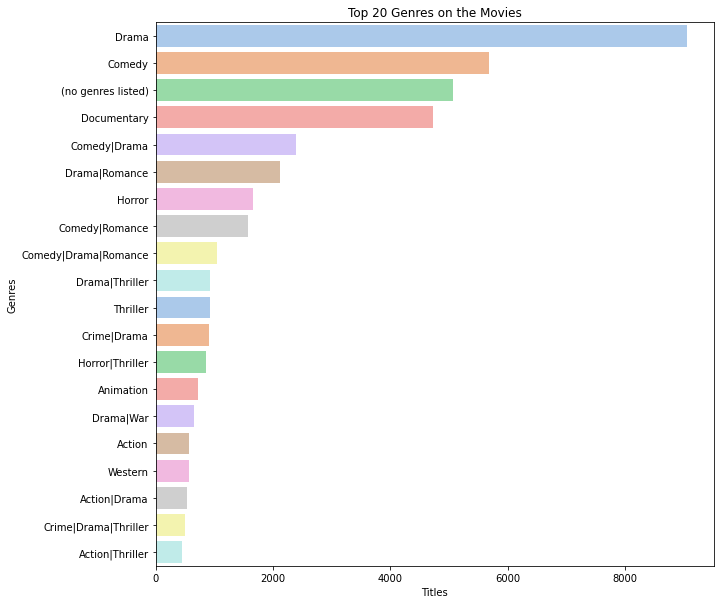

In [27]:
#he top genres that are mostly watched
filtered_genres = movies_df.set_index('title').genres.str.split(', ', expand=True).stack().reset_index(level=1, drop=True);

#bar graph
plt.figure(figsize=(10,10))
g = sns.countplot(y = filtered_genres, order=filtered_genres.value_counts().index[:20], palette='pastel')
plt.title('Top 20 Genres on the Movies')
plt.xlabel('Titles')
plt.ylabel('Genres')
plt.show()

## 3.3. Top Actors based on a number of titles

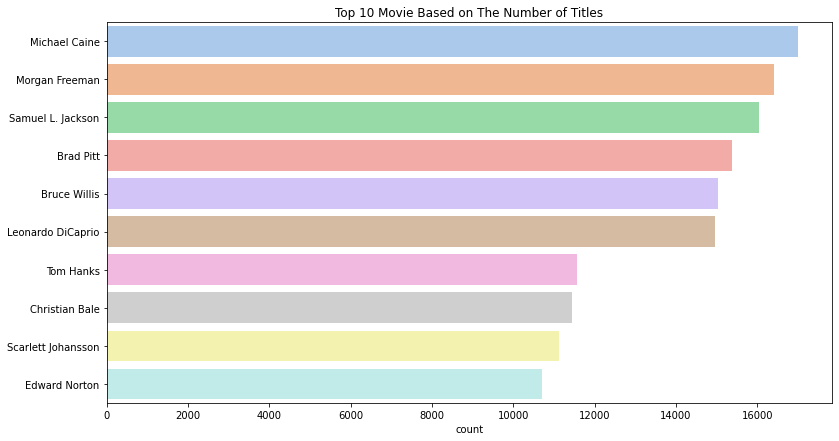

In [28]:
# get the number of casts minus the no cast
filtered_cast_shows = main_df[main_df['title_cast'] != 'No Cast'].set_index('title').title_cast.str.split('|', expand=True).stack().reset_index(level=1, drop=True)

#a bar graph displaying the top actors
plt.figure(figsize=(13,7))
plt.title('Top 10 Movie Based on The Number of Titles')
sns.countplot(y = filtered_cast_shows, order=filtered_cast_shows.value_counts().index[:10], palette='pastel')
plt.show()

## 3.4. Top Movie Directors

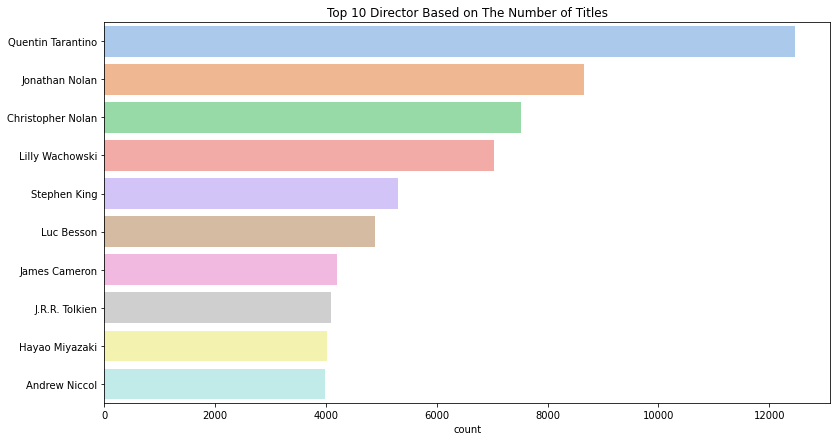

In [29]:
filtered_directors = main_df[main_df.director != 'No Director'].set_index('title').director.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

plt.figure(figsize=(13,7))
plt.title('Top 10 Director Based on The Number of Titles')
sns.countplot(y = filtered_directors, order=filtered_directors.value_counts().index[:10], palette='pastel')

plt.show()

In [30]:
# Extract movies with runtime between 60 and 150 minutes which we believe has the most of the movies.
# also elimiante outliers in this regards.
##main_df = main_df[(main_df.runtime >= 60) & (main_df.runtime <= 150)]
#main_df.shape

In [31]:
#  Seperating the year from the title feature
#main_df['year'] = movies_df['title'].str[-5:-1]#.astype(int)
#main_df['title'] = movies_df['title'].str[:-6]
#main_df.head()

In [32]:
# Fill the null values of director and title_cast with '[]'.
#main_df.director.fillna('[]', inplace=True)
#main_df.title_cast.fillna('[]', inplace=True)
#main_df.plot_keywords.fillna('[]', inplace=True)

# Drop the irrelevant attributes.
#main_df.drop(['budget'],
#               axis=1, inplace=True)
#print(main_df.shape)
#main_df.head()


In [33]:
# Export main_df to movies_metadata_cleaned.csv file.
#import os
#newpath = r"data_cleaned"
#if not os.path.exists(newpath):
#    os.makedirs(newpath)
#main_df.to_csv(newpath + "/movies_metadata_cleaned.csv", index=False)

In [34]:
import plotly.figure_factory as ff

In [35]:
# Heatmap
# Correlation between the feature show with the help of visualisation
corrs = main_df.corr()
fig_heatmap = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
fig_heatmap.update_layout(title= 'Correlation of whole Data',  
                          title_font=dict(size=25, family="Muli, sans-serif"),
                          font=dict(color='#8a8d93'))

<a id="section-two"></a>
## 4. Feature Engineering

In [36]:
movies_ohe = main_df.copy()

In [37]:
# Load genome data.
display_df(genome_scores_df)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [38]:
# Load genome data.
display_df(genome_tags_df)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [39]:
# Inner join genome_tag and genome_scores dataset to ensure we are working with the same set of movies
genomemain_df = genome_scores_df.merge(genome_tags_df, how = 'inner', on = ['tagId'])
print(genomemain_df.shape)
genomemain_df.head()

(15584448, 4)


,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007


In [40]:
# Extract genomemain based on the movies left in the movies_ohe and the relavance should be >= 0.4 out of 1.0
genomemain_df = genomemain_df[(genomemain_df.movieId.isin(movies_ohe.movieId)) & (genomemain_df.relevance >= 0.4)]

# Sort ratings_df by userId and timestamp, then drop the rating and timestamp attributes.
genomemain_df.sort_values(by=['tagId'], ignore_index=True, inplace=True)
genomemain_df.drop(['relevance', 'tag'], axis=1, inplace=True)
print(genomemain_df.shape)
genomemain_df.head()

(847278, 2)


,movieId,tagId
0,10,1
1,33036,1
2,8968,1
3,8772,1
4,8605,1


In [41]:
# Group all movieId by tagId for association rules mining
genomemain_all = genomemain_df.groupby("tagId")["movieId"].apply(list).reset_index()
print(genomemain_all.shape)
genomemain_all.head()

(1128, 2)


,tagId,movieId
0,1,"[10, 33036, 8968, 8772, 8605, 7725, 7573, 7570..."
1,2,"[5796, 36519, 34065, 33861, 7573, 7570, 7197, ..."
2,3,"[8923, 9002, 25767, 8983, 8964, 8898, 8585, 88..."
3,4,"[25755, 25750, 25757, 25759, 25762, 25763, 257..."
4,5,"[8543, 8572, 8600, 8611, 8615, 8616, 8617, 862..."


In [42]:
# Load tags data.

tags_df = pd.read_csv('tags.csv')
print(tags_df.shape)
tags_df.head()

(1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [43]:
# Extract tags based on the movies left in the movies_ohe
tags_df = tags_df[(tags_df.movieId.isin(movies_ohe.movieId))]

# Sort tags_df by userId and timestamp, then drop the tags and timestamp attributes.
tags_df.sort_values(by=['userId', 'timestamp'], ignore_index=True, inplace=True)
tags_df.drop(['tag', 'timestamp'], axis=1, inplace=True)
print(tags_df.shape)
tags_df.head()

(903067, 2)


,userId,movieId
0,3,260
1,3,260
2,4,115569
3,4,7569
4,4,1732


In [44]:
# Group all movieId by userId for association rules mining
tags_all = tags_df.groupby("userId")["movieId"].apply(list).reset_index()
print(tags_all.shape)
tags_all.head()

(13975, 2)


,userId,movieId
0,3,"[260, 260]"
1,4,"[115569, 7569, 1732, 1732, 44665]"
2,19,"[7099, 7099, 7099, 7099, 7099, 7099, 7099, 2160]"
3,20,[1210]
4,43,[434]


### Clean Train Dataset

In [45]:
# Load train data.

display_df(train_df)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


Average rating in dataset: 3.5333951730983424


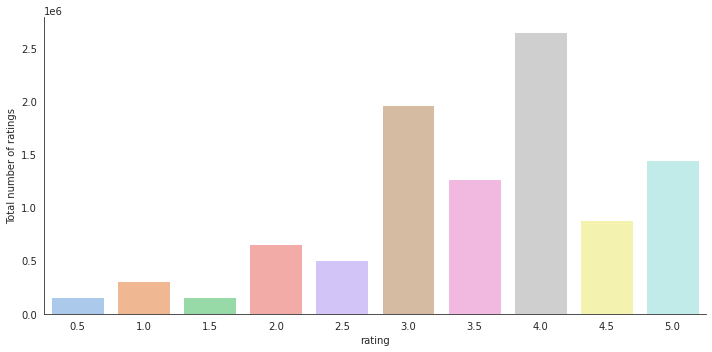

In [46]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train_df, aspect=2.0,kind='count', palette='pastel')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train_df["rating"])}')

In [47]:
# Extract ratings based on the movies left in the movies_ohe and the ratings should be at least 3.5 (out of 5).
#train_df = train_df[(train_df.movieId.isin(movies_ohe.movieId)) & (train_df.rating >= 3.5)]

# Sort ratings_df by userId and timestamp, then drop the rating and timestamp attributes.
#train_df.sort_values(by=['userId', 'timestamp'], ignore_index=True, inplace=True)
#train_df.drop(['timestamp'], axis=1, inplace=True)
#print(train_df.shape)
#train_df.head()

In [48]:
# Group all movieId by userId for association rules mining
train_all = train_df.groupby("userId")["movieId"].apply(list).reset_index()
print(train_all.shape)
train_all.head()

(162541, 2)


,userId,movieId
0,1,"[6954, 1217, 7323, 2632, 1250, 6370, 8685, 793..."
1,2,"[4535, 953, 2501, 2406, 31923, 5418, 2987, 544..."
2,3,"[88125, 4643, 3825, 36519, 1882, 86911, 116797..."
3,4,"[296, 112138, 96610, 589, 76175, 1270, 106916,..."
4,5,"[216, 47, 219, 432, 784, 312, 340, 1265, 1047,..."


<a id="section-two"></a>
## 5. Recommender Systems

In [49]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366426 sha256=6c92d24e1e81521d1dcd64b6670223d883ddc4f962e51f44aa81e241d98794f2
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [50]:
from surprise import Reader, Dataset

In [51]:
train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']].head(750000), Reader())

<a id="three"></a>
### 5.1. Content Filtering-Based Recommender System
<a class="anchor" id="1.1">

<a id="three"></a>
### 5.2. Collaborative Filtering-Based Recommender System
<a class="anchor" id="1.1">

<a id="section-six"></a>
## 6. Model evaluation

<a id="section-seven"></a>
## 7. Model Selection 

<a id="section-seven"></a>
## 8. Conclusion

<a id="section-eight"></a>
## 9. Submission

<a id="three"></a>
### 9.1. Creating pickle files of the models
<a class="anchor" id="1.1">

**bold text**<a id="three"></a>
### 9.2.  Creating kaggle submission file
<a class="anchor" id="1.1">

<a id="section-nine"></a>
## 10. References 